In [331]:
import numpy as np
import matplotlib.pyplot as plt
import random
import time

In [332]:
spins = 10

## Construct a random lattice with spins x spins size
sigmas = np.round(np.random.rand(spins**2))*2-1
lattice = sigmas.reshape((spins, spins))

## The next function returns the total energy of the lattice
def total_energy(lat, J):
    Etot = 0

    for i in range(len(lat)):
        for j in range(len(lat)):
            if i > 0:
                Etot = Etot - (J/2)*lat[i][j]*lat[i-1][j]
            if j > 0:
                Etot = Etot - (J/2)*lat[i][j]*lat[i][j-1]
            if i < len(lat)-1:
                Etot = Etot - (J/2)*lat[i][j]*lat[i+1][j]
            if j < len(lat)-1:
                Etot = Etot - (J/2)*lat[i][j]*lat[i][j+1]

    return Etot

In [333]:
## Now, your turn

def metropolis_step(lat, J, T, kB=1):
  #lat: the input lattice
  #J: the value of the interaction J between spins
  #T: the temperature value
  E_old = total_energy(lat, J)

  j = np.random.randint(len(lat))
  i = np.random.randint(len(lat))
  lat[i][j] *= -1

  E_new = total_energy(lat, J)

  dE = E_new - E_old
  if dE < 0:
    return lat
  
  p = np.random.rand()
  if p < np.exp(-dE/(kB*T)):
    return lat
  
  lat[i][j] *= -1
  return lat

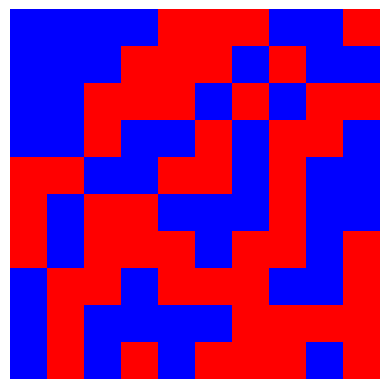

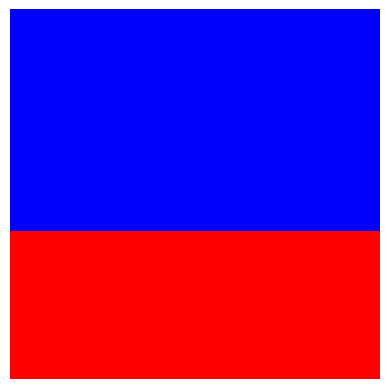


Time elapsed: 2.5145115852355957 seconds


In [334]:
## With your metropolis_step function, try now to perform several steps of Monte Carlo

steps = 10000
J = 1
Temp = 0.1

## Here is a function to visualize the lattice:

def visualizer(lat):
  color_matrix = np.where(lat == 1, 0, 1)
  plt.imshow(color_matrix, cmap = 'bwr', interpolation = 'nearest')
  plt.axis('off')
  plt.show()

start_time = time.time()
visualizer(lattice)

for i in range(steps):
  lattice = metropolis_step(lattice, J, Temp)

visualizer(lattice)
time_elapsed = time.time() -start_time
print(f"\nTime elapsed: {time_elapsed} seconds")


In [ ]:
## Now, let's try to implement the same using bitwise operations
def get_masks():
    right_mask = sum(1 << (i * spins + (spins-1)) for i in range(spins)) #eg 1000 1000 1000 1000 1000 for spins=5
    down_mask = (1 << (spins * (spins - 1))) - 1
    return right_mask, down_mask


In [ ]:
def bitwise_energy(board, J, RIGHT_MASK, DOWN_MASK):
    # horizontal neighbors: shift left (>>1) but mask edges
    hdiff = (board ^ (board >> 1)) & ~RIGHT_MASK #(board >> 1) shift right, then XOR to find differences (different neighbors give 1), then zeros out right edge
    num_diff_h = hdiff.bit_count()

    # vertical neighbors: shift up (>>4), mask top row
    vdiff = (board ^ (board >> spins)) & DOWN_MASK  # mask out top row
    num_diff_v = vdiff.bit_count()
    
    return J * (num_diff_h + num_diff_v - spins * (spins-1))

def bitwise_metropolis_step(board, J, T, kB, no_of_bits, RIGHT_MASK, DOWN_MASK):
  E_old = bitwise_energy(board, J, RIGHT_MASK, DOWN_MASK)

  j = np.random.randint(no_of_bits)
  bit_swap = 1 << j
  board ^= bit_swap

  E_new = bitwise_energy(board, J, RIGHT_MASK, DOWN_MASK)

  dE = E_new - E_old
  if dE < 0:
    return board
  
  p = np.random.rand()
  if p < np.exp(-dE/(kB*T)):
    return board
  
  board ^= bit_swap
  return board

In [ ]:
## With your metropolis_step function, try now to perform several steps of Monte Carlo

steps = 10000
J = 1
T = 0.1
kB = 1
no_of_bits = spins**2
board = random.getrandbits(no_of_bits) #random initial state, a board of 0s and 1s
RIGHT_MASK, DOWN_MASK = get_masks()

def bitwise_visualizer(board):
  for i in range(spins): #row_wise
    row = ""
    for j in range(spins):
      row += str((board >> (j+(spins*i))) & 1)
    print(row)

start_time = time.time()
print("Initial state:")
bitwise_visualizer(board)

for i in range(steps):
  board = bitwise_metropolis_step(board, J, T, kB, no_of_bits, RIGHT_MASK, DOWN_MASK)

print("\nFinal state:")
bitwise_visualizer(board)
time_elapsed = time.time() -start_time
print(f"\nTime elapsed: {time_elapsed} seconds")

print(149
+15
+19
+29
+25
+45
+29
+39
+49
+59
+199
+29
+89
+39)

Initial state:
0110100010
1110001110
0110111101
1010101101
1111110110
1001110011
0010110010
1100100110
0101110011
1110001000

Final state:
1111111111
1111111111
1111111111
1111111111
1111111111
1111111111
1111111111
1111111111
1111111111
1111111111

Time elapsed: 0.03569197654724121 seconds
814
